In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.50.post1', '1.0.1.post2')

In [4]:
torch.cuda.set_device(0)

In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model')

In [6]:
p = path.glob('MarathiWikipediaArticles/*')
files = [x for x in p if x.is_file()]

In [7]:
len(files)

85537

In [8]:
train_files, test_files = train_test_split(files, test_size=0.3)

In [9]:
len(train_files), len(test_files)

(59875, 25662)

In [10]:
train_files[0]

PosixPath('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model/MarathiWikipediaArticles/24822.pkl')

In [11]:
str(train_files[0]).split('/')[-1][:-4]

'24822'

In [12]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MarathiDataset'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [13]:
for file in test_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MarathiDataset'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [6]:
from inltk.tokenizer import MarathiTokenizer

In [7]:
MarathiTokenizer

inltk.tokenizer.MarathiTokenizer

In [8]:
# class MarathiTokenizer(BaseTokenizer):
#     def __init__(self, lang:str):
#         self.lang = lang
#         self.sp = spm.SentencePieceProcessor()
#         self.sp.Load(str(path/"../tokenizer/marathi_lm.model"))
        
#     def tokenizer(self, t:str) -> List[str]:
#         return self.sp.EncodeAsPieces(t)

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [10]:
# 30,000 is the vocab size that we chose in sentencepiece
marathi_vocab = Vocab(itos)

In [11]:
tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [12]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [14]:
data_lm = TextLMDataBunch.from_folder(path=path/'MarathiDataset', tokenizer=tokenizer, vocab=marathi_vocab)

In [15]:
data_lm.batch_size

64

In [16]:
data_lm.save()

In [23]:
data_lm.show_batch()

idx,text
0,▁x x bo s ▁घनमीटर ▁हे ▁आकारमान ▁मोजण्या चे ▁एक ▁एकक ▁आहे . ▁१ ▁मी ▁ x ▁१ ▁मी ▁ x ▁१ ▁मी ▁एवढ्या ▁क्षेत्राचे ▁आकारमान ▁१ ▁घनमीटर ▁असते . ▁x x bo s ▁अल्माटी ▁हा ▁मध्य ▁आशियातील ▁कझाकस्तान ▁देशाचा ▁एक ▁प्रांत ▁आहे . ▁अल्माटी ▁ह्याच ▁नावाचे ▁मोठे ▁शहर ▁ह ्य ▁प्रांत ाच्या ▁अंतर्गत ▁असले ▁तरी ▁ते ▁राजकीय ▁दृष्ट्या ▁अल्माटी ▁प्रांत ाचा ▁भाग ▁नसून ▁एक ▁स्वायत्त ▁शहर ▁आहे . ▁गुणक
1,. ▁तसेच ▁टायगर ▁कॅपिटल ▁ऑफ ▁इंडिया ▁पण ▁सं भो तात . ▁नागपुर ास ▁संत ्रा नगरी ▁असे ही ▁संबोधतात ▁कारण ▁शहरातील ▁संत ्री ▁प्रसिद्ध ▁आहेत . ▁मोठ्या ▁प्रमाणावर ▁संत्र्या चे ▁पिके ▁येथे ▁होतात . ▁संत्र्या च्या ▁बागा ▁मोठ्या ▁प्रमाणावर ▁आढळून ▁येतात . ▁त्यामुळे ▁संत्र्या ची ▁मोठी ▁बाजारपेठ ▁येथे ▁आहे . ▁ नुकताच ▁2002 ▁मध्ये ▁शहराचा ▁३०० वा ▁वर्धा पन दिन ▁साजरा ▁करण्यात ▁आला . ▁नजिकच्या ▁आ थि र्क ▁गुंतवणूक ीमुळे
2,▁या ▁विभागात ▁समावेश ▁होतो . ▁कोत े ▁पाटील ांच्या ▁नावावरून ▁कोथरूड ▁असे ▁नाव ▁पडले ▁असा ▁एक ▁प्र वाद ▁आहे . . ▁पुरेसे ▁ऐतिहासिक ▁पुरावे ▁उपलब्ध ▁नसले ▁तरीही ▁थोरले ▁बाजीराव ांच्या ▁काळात ▁त्यांच्या ▁द्वितीय ▁भार ्या ▁मस्तानी ▁यांचा ▁महाल ही ▁कोथरूड ▁बाग ▁परिसरात ▁असावा ▁असे ▁मानले ▁जात ▁असे . ▁कोथरूड ▁गावठाण ▁येथे ▁नाना ▁फडणवीस ▁यांची ▁पेरू ची ▁बाग ▁होती . त्यांच्या ▁पश्चात ▁ब्रिटिश ▁काळातील ▁कलेक्टर ▁मॉर्गन ▁यांनी ▁काढलेल्या ▁लिलाव ात ▁हि
3,"ur se . ▁it ▁cr os s es ▁ ri ver ava ri ▁near ▁k op ar ga on , ▁the ava ra ▁near ▁k ol har , ▁the la ▁near hu ri ▁and ▁the ▁b hi ma ▁near ▁the ▁ district ▁b order ▁where ▁there ▁are ▁ br id ge s . ▁it ▁cr os s es ▁a ▁major ▁na ll ah"
4,"▁my ▁place . ▁he ▁who ▁so ▁ ack n ow led ge s ▁it ▁will ▁ o b ta in ▁his ▁re ward . ▁the ▁will ▁ res cu e ▁him . ▁k n ow ▁this ▁as ▁the ▁truth "" . ▁g obind ▁thus ▁pass ed ▁on ▁the ▁success ion ▁with ▁du e ▁ceremony ▁to ▁the ly o k , ▁the"


In [17]:
len(data_lm.vocab.itos)

30000

In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

/home/gaurav/anaconda3/envs/fastai-bleed/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [19]:
gc.collect()

49

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


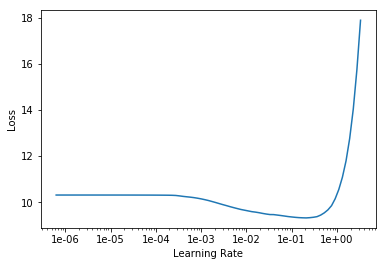

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.510442,4.438874,0.315410


In [30]:
learn.save('first', with_opt=True)

In [31]:
learn.load('first', with_opt=True);

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.382417,4.451831,0.310669
2,4.379301,4.400976,0.312358
3,4.051602,4.094686,0.342677
4,3.679856,3.718292,0.392597
5,3.327582,3.598108,0.410449


In [34]:
learn.save('second_gu_lm', with_opt=True)

In [35]:
learn.load('second_gu_lm', with_opt=True);

In [36]:
learn.fit_one_cycle(40, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.421837,3.589710,0.411864
2,3.283107,3.579655,0.413513
3,3.311975,3.565250,0.415898
4,3.144865,3.546464,0.419021
5,3.390587,3.524449,0.422398
6,3.243941,3.498798,0.426690
7,3.236669,3.473009,0.431035
8,3.384805,3.440805,0.436178
9,3.314674,3.411994,0.441093
10,3.268296,3.384046,0.445948


In [37]:
learn.save('third_mr_lm', with_opt=True)

In [38]:
learn.load('third_mr_lm', with_opt=True);

In [39]:
learn.fit_one_cycle(20, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.439824,2.914547,0.528714
2,2.477008,2.914123,0.528784
3,2.462474,2.913254,0.528912
4,2.525224,2.912550,0.529204
5,2.542871,2.911019,0.529602
6,2.473117,2.909723,0.529762
7,2.483403,2.906476,0.530446
8,2.543327,2.904446,0.530686
9,2.528812,2.902434,0.531177
10,2.589246,2.900583,0.531355


In [46]:
learn.save('fourth_mr_lm', with_opt=True)

In [20]:
learn.load('fourth_mr_lm', with_opt=True);

In [21]:
TEXT = "तसेच टायगर कॅपिटल"
N_WORDS = 40
N_SENTENCES = 2

In [22]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

तसेच टायगर कॅपिटल ▁अँड ▁कंपनी ▁ऑफ ▁इंडिया ▁जी सं कल न ▁या ▁नावाने ▁ओळखले ▁जाते . ▁भारत ▁देशाची ▁अर्थव्यवस्था ▁१२ . ५ ▁दशलक्ष ▁२५ ▁लाख ▁' २०११ ▁बनली ▁आहे . ▁या ▁उद्योग ांपासून ▁बहु सांस्कृतिक ▁आणि ▁औद्योगिक ▁उत्पादन ांची ▁गुंतवणूक ▁केली ▁आहे .
तसेच टायगर कॅपिटल ▁अँड ▁लुकास ▁क्लब ▁तथा ▁पी ▁पार्क ▁हे ▁भारतातील ▁सर्वात ▁जास्त ▁परिपूर्ण ▁मैदान ▁आहे . ▁दक्षिण ▁विभाग , ▁चेन्नई ▁आणि ▁साखळी ▁स्पर्धेत ून 2-1 1 ▁सी के चा ▁मँचेस्टर ▁हा ▁जगातील ▁सर्वाधिक ▁लोकप्रिय ▁मीडिया ▁म्हणून ▁ओळखला ▁जातो . ▁लॉर्ड ▁ए ण्ड


In [45]:
np.exp(2.89)

17.99330960155032

In [23]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [13]:
# Generating embedding vectors for visualization

In [14]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model')

In [15]:
defaults.device = torch.device('cpu')

In [16]:
learn = load_learner(path / 'MarathiDataset/')

In [17]:
encoder = get_model(learn.model)[0]

In [18]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 400])

In [19]:
embeddings = encoder.state_dict()['encoder.weight']

In [20]:
embeddings = np.array(embeddings)

In [21]:
embeddings[0].shape

(400,)

In [22]:
df = pd.DataFrame(embeddings)

In [23]:
df.shape

(30000, 400)

In [25]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [24]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.312169,-0.032875,0.062798,-0.632392,-0.282446,0.538549,-1.447100,0.490964,0.769537,0.550511,...,0.302092,0.409125,-1.094941,0.156421,-0.025080,0.170279,-0.216644,-0.061538,0.431516,-0.158912
1,0.303554,0.202227,-0.052628,0.084942,-0.103308,0.609034,-0.546176,0.252460,-0.135614,-0.086010,...,0.568707,0.134960,-0.834310,-0.154317,-0.046771,-0.107694,0.074592,0.018604,-0.032157,-0.026727
2,0.326993,0.179803,-0.055509,0.088163,-0.086686,0.623170,-0.558620,0.250124,-0.125111,-0.087374,...,0.548643,0.141399,-0.840439,-0.142019,-0.054021,-0.117791,0.054455,0.020440,-0.046853,-0.026599
3,-0.375358,-0.455526,0.359641,-0.349043,0.177527,-0.047528,0.322523,0.285699,0.093311,0.463164,...,0.123783,-0.187585,-1.186277,-1.102160,-0.782112,-0.492201,-0.771446,-0.039537,-1.166200,0.092839
4,-0.203419,-0.222257,-0.027218,0.062073,-0.004343,0.679432,0.140100,-0.051899,0.104761,-0.040783,...,-0.113843,0.179509,-0.929239,0.022596,0.370759,-0.237825,-0.010258,0.073941,-0.712990,0.189085


In [26]:
df2 = pd.DataFrame(itos)

In [27]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,▁


In [28]:
df2.shape

(30000, 1)

In [29]:
df2.to_csv('embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [30]:
encoder.state_dict()['encoder.weight'][1]

tensor([ 3.0355e-01,  2.0223e-01, -5.2628e-02,  8.4942e-02, -1.0331e-01,
         6.0903e-01, -5.4618e-01,  2.5246e-01, -1.3561e-01, -8.6010e-02,
        -1.5868e-01,  3.3899e-01, -4.0738e-02, -2.4026e-01,  2.0038e-01,
         7.2730e-02, -3.0973e-01, -7.2570e-01,  3.7218e-02,  6.1657e-02,
        -2.3423e-02, -1.7355e-01, -6.0471e-02,  2.8801e-01, -4.2690e-01,
        -5.5867e-01,  1.1975e-01,  2.8651e-01, -1.1228e-02, -1.9044e-01,
         1.0093e-02,  1.2312e-01,  1.4157e-02, -2.5520e-01, -5.5532e-02,
        -8.3337e-02, -2.9266e-01, -4.4704e-02, -3.3126e-01,  1.4800e-01,
         7.8194e-02,  3.5224e-01,  1.7638e-01, -3.3904e-01, -1.5751e-01,
         1.3568e-02, -1.1143e-01,  2.4866e-01, -1.3968e-01, -2.0744e-01,
        -1.1968e-01, -1.4435e-01,  1.2408e-01, -3.6505e-01, -1.2983e-03,
        -2.9173e-01,  1.9681e-01, -5.3077e-01,  8.7970e-03,  4.7541e-02,
        -2.3006e-01,  3.0428e-01, -5.2922e-02,  2.8186e-01,  2.2882e-02,
        -2.3753e-01, -9.2308e-02,  4.6068e-01,  2.1